In [43]:
import os
import sys
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score, auc, precision_recall_curve
from sklearn.metrics import average_precision_score

np.random.seed(2019)

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import lightgbm as lgb

In [44]:
base_path = os.path.abspath('../..')
data_path = os.path.join(base_path, 'data')
database_path = os.path.join(data_path, 'database')
strategy_path = os.path.join(base_path, 'strategy')
sys.path.append(strategy_path)

In [45]:
from strategy import CommodityStrategy, EquityStrategy, IRStrategy, EmergingStrategy
from tester import Tester

In [46]:
from models.CRNN import CRNN_model

# 1. Data

In [47]:
strategy = EquityStrategy(strategy_name="EPM", asset_type="EQUITY")
strategy.load_index_and_return(from_db=False, save_file=False)

2019-10-30 18:09:07,937 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-30 18:09:07,937 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-30 18:09:07,938 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-30 18:09:07,938 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-30 18:09:07,939 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-30 18:09:07,939 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [48]:
strategy.index.columns.name = 'ticker'
strategy.ret.columns.name = 'ticker'

In [49]:
strategy.index.drop_duplicates(inplace=True)
strategy.ret.drop_duplicates(inplace=True)

In [50]:
df_index = strategy.index.loc[:'2019-07']
df_index_return = strategy.ret.loc[:'2019-07']

# 2. Explore

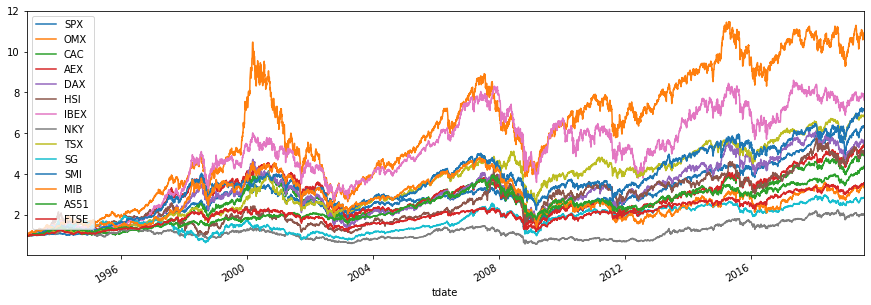

In [51]:
plt.figure(figsize=(15,5))
for column in df_index.columns:
    df_index[column].plot()
plt.legend()

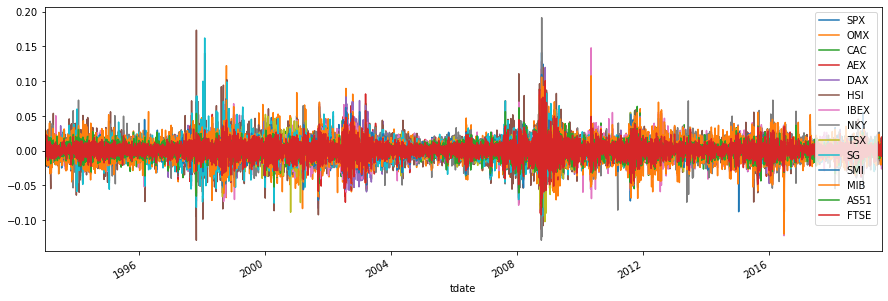

In [52]:
plt.figure(figsize=(15,5))
for column in df_index_return.columns:
    df_index_return[column].plot()
plt.legend()

# 3. Model

### CROSS SECTIONAL

In [53]:
indiv_momentum_lst = [5, 10, 21, 42, 63, 126, 189, 252]

## 1. X

### moving average 와 주가 차이

In [68]:
moving_avg = {}

for i, period in enumerate(indiv_momentum_lst):
    moving_avg['moving_average_' + str(period)] = df_index.rolling(period).mean() - df_index

### moving average  ratio

In [69]:
moving_avg_ratio = {}
moving_avg_ratio_diff = {}

for i, period in enumerate(indiv_momentum_lst):
    moving_avg_ratio['moving_average_ratio_' + str(period)] = df_index.rolling(period).mean() / df_index
    moving_avg_ratio_diff['moving_average_ratio_diff_' + str(period)] = moving_avg_ratio['moving_average_ratio_' + str(period)].diff(period)

In [70]:
df_moving_avg = pd.concat(moving_avg, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_moving_avg_ratio = pd.concat(moving_avg_ratio, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_moving_avg_ratio_diff = pd.concat(moving_avg_ratio_diff, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]

### moving average ratio 간 차이

In [71]:
moving_avg_columns = df_moving_avg_ratio.columns

for i, column1 in enumerate(moving_avg_columns[1:]):
    for j, column2 in enumerate(moving_avg_columns[2+i:]):
        df_moving_avg_ratio[column2 + " - " + column1] = df_moving_avg_ratio[column1] - df_moving_avg_ratio[column2]

# CASE 0. 기존

<img src="./result/EPM_PAST.png">

<img src="./result/EPM.png">

- 빨간색이 CROSS SECTIONAL 임

# CASE 1. BINARY

- Binary로 나누어서 학습하고 상위 30% 하위 30% 롱숏

In [72]:
one_week = 5
one_month = 20

In [73]:
df_index_rank = df_index.pct_change(one_week).shift(-1 * one_week).rank(axis=1) 

### binary - 50%

In [74]:
df_index_y_binary = df_index_rank > 7.5
df_index_y_binary = df_index_y_binary.astype(np.float32)

In [75]:
df_y = df_index_y_binary.unstack().reset_index()
df_y = df_y.set_index('tdate').loc['1994':]
df_y.columns = ['ticker', 'y']

In [76]:
df_moving_avg.reset_index(inplace=True)
df_moving_avg_ratio.reset_index(inplace=True)

df_join = pd.merge(df_y, df_moving_avg, on=['tdate', 'ticker'])
df_join = pd.merge(df_join, df_moving_avg_ratio, on=['tdate', 'ticker'])
df_join = pd.merge(df_join, df_moving_avg_ratio_diff, on=['tdate', 'ticker'])

In [78]:
df_train = df_join.loc[df_join['tdate'] <= pd.to_datetime('2010-12-31')]
df_val = df_join.loc[(df_join['tdate'] >= pd.to_datetime('2009-01-01')) & (df_join['tdate'] <= pd.to_datetime('2010-12-31'))]
df_test = df_join.loc[df_join['tdate'] >= pd.to_datetime('2011-01-01')]

df_train_y = df_train['y']
df_train_x = df_train[df_train.columns[3:]]

df_val_y = df_val['y']
df_val_x = df_val[df_val.columns[3:]]

df_test_y = df_test['y']
df_test_x = df_test[df_test.columns[3:]]

In [80]:
def train(train_x, train_y1, val_x, val_y1, num_boost_round=1000, learning_rate=0.01, early_stopping_rounds=50, verbose=None):
    params1 = {"objective": "binary",
          "boosting_type": "gbdt",
          "num_boost_round": num_boost_round,
          'max_depth': 3,
          'num_leaves': 25,
          "learning_rate": learning_rate,
          "feature_fraction": 0.8,
          "subsample": 0.8,
          "verbosity": 1,
          "metric": 'binary_logloss'
          }              
    
    train_data = lgb.Dataset(train_x, train_y1)
    val_data = lgb.Dataset(val_x, val_y1)
    lgb_model = lgb.train(train_set=train_data, params=params1, early_stopping_rounds=early_stopping_rounds,
                          valid_sets=[train_data, val_data], verbose_eval=verbose)
    
    train_pred = lgb_model.predict(train_x)
    val_pred = lgb_model.predict(val_x)
    return lgb_model, train_pred, val_pred

In [81]:
lgb_models = []
lgb_train_pred1 = []
lgb_val_pred1 = []

model, train_pred, val_pred = train(df_train_x.values, df_train_y.values, df_train_x.values, df_train_y.values, 
                                    num_boost_round=500, 
                                    learning_rate=0.01, 
                                    verbose=10,
                                    early_stopping_rounds=500)

Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.692683	valid_1's binary_logloss: 0.692683
[20]	training's binary_logloss: 0.692278	valid_1's binary_logloss: 0.692278
[30]	training's binary_logloss: 0.691921	valid_1's binary_logloss: 0.691921
[40]	training's binary_logloss: 0.691605	valid_1's binary_logloss: 0.691605
[50]	training's binary_logloss: 0.691321	valid_1's binary_logloss: 0.691321
[60]	training's binary_logloss: 0.691066	valid_1's binary_logloss: 0.691066
[70]	training's binary_logloss: 0.690824	valid_1's binary_logloss: 0.690824
[80]	training's binary_logloss: 0.690598	valid_1's binary_logloss: 0.690598
[90]	training's binary_logloss: 0.690383	valid_1's binary_logloss: 0.690383
[100]	training's binary_logloss: 0.690183	valid_1's binary_logloss: 0.690183
[110]	training's binary_logloss: 0.689992	valid_1's binary_logloss: 0.689992
[120]	training's binary_logloss: 0.689812	valid_1's binary_logloss: 0.689812
[130]	training's binary

In [82]:
test_pred = model.predict(df_test_x.values)

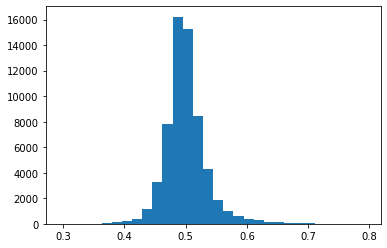

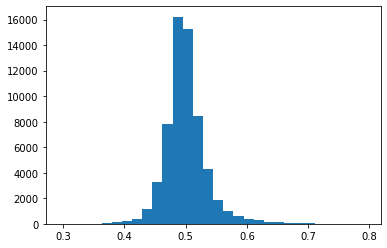

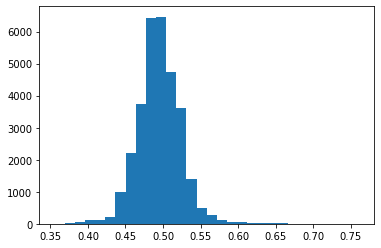

In [83]:
plt.hist(train_pred, bins=30)
plt.show()

plt.hist(val_pred, bins=30)
plt.show()

plt.hist(test_pred, bins=30)
plt.show()

### 결과

In [84]:
df_train['y_pred'] = train_pred
df_test['y_pred'] = test_pred

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [85]:
df_train_pred = pd.pivot_table(df_train, columns='ticker', index='tdate', values='y_pred')
df_test_pred = pd.pivot_table(df_test, columns='ticker', index='tdate', values='y_pred')

In [86]:
df_pred = pd.concat([df_train_pred, df_test_pred], axis=0)

In [87]:
df_index_sub = df_index.loc['1994':]

In [88]:
long = df_pred.shape[1] / 10 * 7
short = df_pred.shape[1] / 10 * 3

df_pred_rank = df_pred.rank(axis=1)
df_pred_long = (df_pred_rank > long).astype(np.float32)
df_pred_short = (df_pred_rank < short).astype(np.float32)
df_pred_long_short = df_pred_long - df_pred_short

In [89]:
strategy.TSRV = df_pred_long_short
strategy.CSRV = df_pred_long_short

In [90]:
strategy.set_rebalance_period(freq='week', rebalance_weekday=1) 

2019-10-30 18:10:41,894 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 18:10:41,894 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD


In [91]:
tester = Tester(strategy)

In [92]:
tsrv_cum_return, tsrv_summary = tester.test_ts_signal()
csrv_cum_return, csrv_summary = tester.test_cs_signal()

C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:29: RuntimeWarning: divide by zero encountered in true_divide
  tsrv_port = pd.DataFrame(tsrv_sig.to_numpy() / tsrv_sig.sum(axis=1).values.reshape(-1, 1), columns=tsrv_sig.columns, index=tsrv_sig.index)
C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:29: RuntimeWarning: invalid value encountered in true_divide
  tsrv_port = pd.DataFrame(tsrv_sig.to_numpy() / tsrv_sig.sum(axis=1).values.reshape(-1, 1), columns=tsrv_sig.columns, index=tsrv_sig.index)
C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:39: RuntimeWarning: divide by zero encountered in true_divide
  csrv_port = pd.DataFrame(csrv_sig.to_numpy() / csrv_sig.sum(axis=1).values.reshape(-1, 1), columns=csrv_sig.columns, index=csrv_sig.index)
C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:39: RuntimeWarning: invalid value encountered in

In [93]:
strategy.set_portfolio_parameter(cs_strategy_type='vol')
strategy.make_portfolio()

2019-10-30 18:10:43,782 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 18:10:43,782 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 18:10:43,783 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 18:10:43,783 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 18:10:43,784 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 18:10:43,784 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 18:10:57,825 - EPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-30 18:10:57,825 - EPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-30 18:10:57,826 - EPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2019-10-30 18:10:57,826 - EPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2019-10-30 18:10:59,430 - EPM - INFO - [STEP 5 - 2 - 2] TARGET VOL CONTROL to TS POSITION
2019-10-30 18:10:59,430 - EPM - INFO - [STEP 5 - 2 - 2] TARGET VOL CONTROL to TS POSITION
2019-10-30 18:10:59,437 - EPM - INFO - [STEP 5 - 2 - 3] STRATEGY LEVEL VOL CONTR

### TRAIN

2019-10-30 18:11:10,135 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 18:11:10,135 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 18:11:10,136 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 18:11:10,136 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 18:11:10,145 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 18:11:10,145 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 18:11:10,153 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-30 18:11:10,153 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT


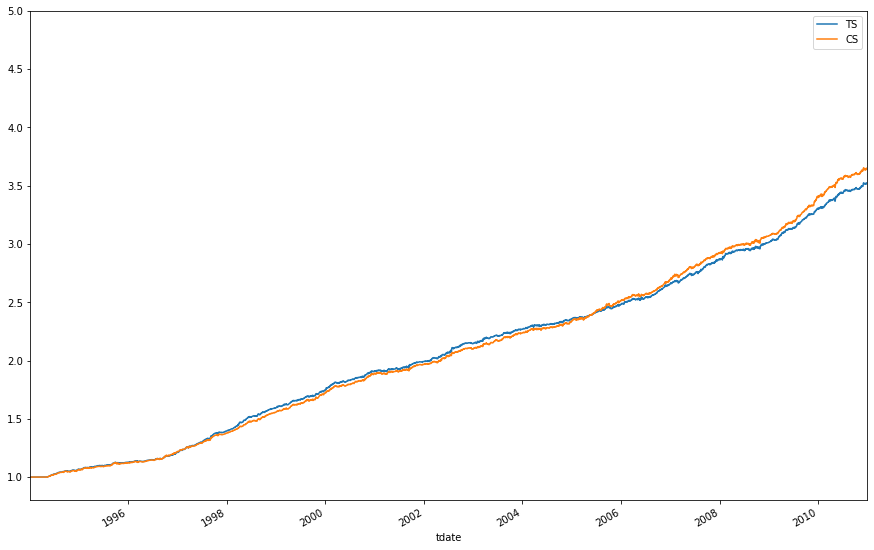

In [94]:
tester = Tester(strategy)
tester.set_period(start='1994-01-01', end='2010-12-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.8, 5))

### TEST

2019-10-30 18:11:10,306 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 18:11:10,306 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 18:11:10,307 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 18:11:10,307 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 18:11:10,314 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 18:11:10,314 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 18:11:10,321 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-30 18:11:10,321 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT


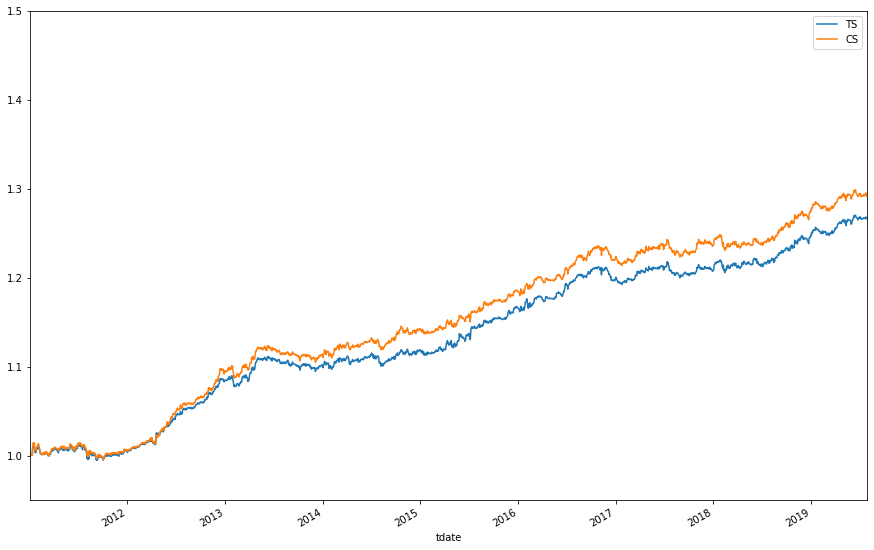

In [95]:
tester = Tester(strategy)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False,ylim=(0.95, 1.5))

# CASE 2. BINARY 30% 70%


- 상위 30%에 속하는 데이터와 하위 30%에 속하는 데이터로 학습한다.

In [96]:
one_week = 5
one_month = 20

df_index_rank = df_index.pct_change(one_week).shift(-1 * one_week).rank(axis=1) 

df_index_y_binary30_1 = df_index_rank > 7/10 * df_index_rank.shape[1]
df_index_y_binary30_1 = df_index_y_binary30_1.astype(np.float32)

df_index_y_binary30_2 = df_index_rank < 3/10 * df_index_rank.shape[1]
df_index_y_binary30_2 = df_index_y_binary30_2.astype(np.float32)

In [97]:
df_index_y_binary30_1 = df_index_y_binary30_1.unstack().reset_index()
df_index_y_binary30_1.columns = ['ticker', 'tdate', 'info']

df_index_y_binary30_2 = df_index_y_binary30_2.unstack().reset_index()
df_index_y_binary30_2.columns = ['ticker', 'tdate', 'info']

In [98]:
df_index_y_binary30_1 = df_index_y_binary30_1[df_index_y_binary30_1['info'] == 1]
df_index_y_binary30_2 = df_index_y_binary30_2[df_index_y_binary30_2['info'] == 1]
df_index_y_binary30 = pd.concat([df_index_y_binary30_1, df_index_y_binary30_2], axis=0)

In [99]:
df_y2 = df_index_y_binary.unstack().reset_index()
df_y2.columns = ['ticker', 'tdate', 'y']
df_y2 = pd.merge(df_y2, df_index_y_binary30, on=['ticker', 'tdate'])

In [101]:
df_join2 = pd.merge(df_y2, df_moving_avg, on=['tdate', 'ticker'])
df_join2 = pd.merge(df_join2, df_moving_avg_ratio, on=['tdate', 'ticker'])
df_join2 = pd.merge(df_join2, df_moving_avg_ratio_diff, on=['tdate', 'ticker'])

In [102]:
df_train = df_join2.loc[df_join2['tdate'] <= pd.to_datetime('2010-12-31')]
df_val = df_join.loc[(df_join['tdate'] >= pd.to_datetime('2009-01-01')) & (df_join2['tdate'] <= pd.to_datetime('2010-12-31'))]
df_test = df_join.loc[df_join['tdate'] >= pd.to_datetime('2011-01-01')]

df_train_y = df_train['y']
df_train_x = df_train[df_train.columns[4:]]

df_val_y = df_val['y']
df_val_x = df_val[df_val.columns[3:]]

df_test_y = df_test['y']
df_test_x = df_test[df_test.columns[3:]]

In [103]:
model2, train_pred2, val_pred2 = train(df_train_x.values, df_train_y.values, df_val_x.values, df_val_y.values, 
                                    num_boost_round=500, 
                                    learning_rate=0.01, 
                                    verbose=10,
                                    early_stopping_rounds=500)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.686128	valid_1's binary_logloss: 0.697366
[20]	training's binary_logloss: 0.685419	valid_1's binary_logloss: 0.697028
[30]	training's binary_logloss: 0.684775	valid_1's binary_logloss: 0.696752
[40]	training's binary_logloss: 0.684213	valid_1's binary_logloss: 0.69658
[50]	training's binary_logloss: 0.683713	valid_1's binary_logloss: 0.696417
[60]	training's binary_logloss: 0.683247	valid_1's binary_logloss: 0.696299
[70]	training's binary_logloss: 0.682818	valid_1's binary_logloss: 0.696192
[80]	training's binary_logloss: 0.682432	valid_1's binary_logloss: 0.696092
[90]	training's binary_logloss: 0.682029	valid_1's binary_logloss: 0.695995
[100]	training's binary_logloss: 0.681654	valid_1's binary_logloss: 0.695939
[110]	training's binary_logloss: 0.681312	valid_1's binary_logloss: 0.695905
[120]	training's binary_logloss: 0.680952	valid_1's binary_logloss: 0.695866
[130]	training's binary_

In [104]:
df_pred2 = df_join.copy()
pred2 = model2.predict(df_join[df_join.columns[3:]].values)
df_pred2['y_pred'] = pred2
df_pred2 = pd.pivot_table(df_pred2, columns='ticker', index='tdate', values='y_pred')

(array([5.0000e+00, 1.6000e+01, 4.2000e+01, 7.1000e+01, 1.6200e+02,
        2.7700e+02, 3.8000e+02, 6.2500e+02, 1.4880e+03, 3.9990e+03,
        8.2530e+03, 1.3164e+04, 1.7314e+04, 1.5590e+04, 1.1280e+04,
        8.1070e+03, 6.2820e+03, 2.9610e+03, 1.1490e+03, 6.6900e+02,
        4.0700e+02, 3.3100e+02, 2.3000e+02, 1.6500e+02, 9.0000e+01,
        5.0000e+01, 2.4000e+01, 3.1000e+01, 1.3000e+01, 9.0000e+00]),
 array([0.331205  , 0.34806335, 0.36492169, 0.38178004, 0.39863839,
        0.41549674, 0.43235509, 0.44921343, 0.46607178, 0.48293013,
        0.49978848, 0.51664682, 0.53350517, 0.55036352, 0.56722187,
        0.58408022, 0.60093856, 0.61779691, 0.63465526, 0.65151361,
        0.66837196, 0.6852303 , 0.70208865, 0.718947  , 0.73580535,
        0.7526637 , 0.76952204, 0.78638039, 0.80323874, 0.82009709,
        0.83695544]),
 <a list of 30 Patch objects>)

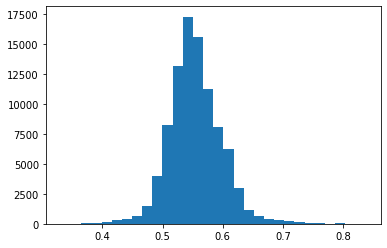

In [105]:
plt.hist(pred2, bins=30)

In [106]:
long = df_pred2.shape[1] / 10 * 7
short = df_pred2.shape[1] / 10 * 3

df_pred_rank2 = df_pred2.rank(axis=1)

df_pred_long2 = (df_pred_rank2 > long).astype(np.float32)
df_pred_short2 = (df_pred_rank2 < short).astype(np.float32)
df_pred_long_short2 = df_pred_long2 - df_pred_short2

In [107]:
strategy2 = EquityStrategy(strategy_name="EPM", asset_type="EQUITY")
strategy2.load_index_and_return(from_db=False, save_file=False)
strategy2.index.columns.name = 'ticker'
strategy2.ret.columns.name = 'ticker'
strategy2.index.drop_duplicates(inplace=True)
strategy2.ret.drop_duplicates(inplace=True)

2019-10-30 18:12:04,677 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-30 18:12:04,677 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-30 18:12:04,677 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-30 18:12:04,679 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-30 18:12:04,679 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-30 18:12:04,679 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-30 18:12:04,680 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-30 18:12:04,680 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-30 18:12:04,680 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [108]:
strategy2.TSRV = df_pred_long_short2
strategy2.CSRV = df_pred_long_short2

strategy2.set_rebalance_period(freq='week', rebalance_weekday=1) 
strategy2.set_portfolio_parameter(cs_strategy_type='vol')
strategy2.make_portfolio()

2019-10-30 18:12:06,596 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 18:12:06,596 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 18:12:06,596 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 18:12:06,598 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 18:12:06,598 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 18:12:06,598 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 18:12:06,599 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 18:12:06,599 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 18:12:06,599 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 18:12:06,600 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 18:12:06,600 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 18:12:06,600 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 18:12:20,613 - EPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-30 18:12:20,613 - EPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-30 18:12:20,613 - EPM -

### TRAIN

2019-10-30 18:14:14,386 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 18:14:14,386 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 18:14:14,386 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 18:14:14,386 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 18:14:14,386 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 18:14:14,388 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 18:14:14,388 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 18:14:14,388 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 18:14:14,388 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 18:14:14,388 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 18:14:14,397 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 18:14:14,397 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 18:14:14,397 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 18:14:14,397 - EPM - INFO - [STEP 6 - 2] BACKT

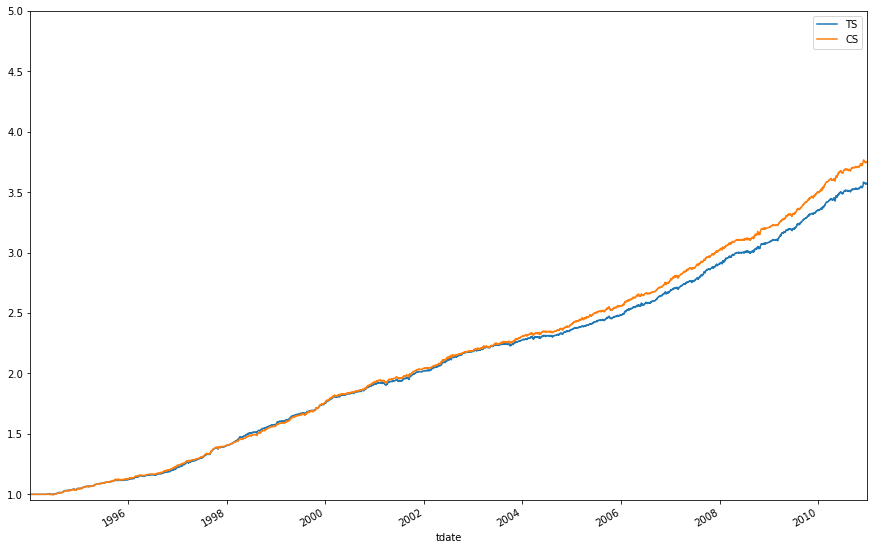

In [131]:
tester = Tester(strategy2)
tester.set_period(start='1994-01-01', end='2010-12-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.95, 5))

### TEST

2019-10-30 18:14:08,729 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 18:14:08,729 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 18:14:08,729 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 18:14:08,729 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 18:14:08,729 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 18:14:08,732 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 18:14:08,732 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 18:14:08,732 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 18:14:08,732 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 18:14:08,732 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 18:14:08,740 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 18:14:08,740 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 18:14:08,740 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 18:14:08,740 - EPM - INFO - [STEP 6 - 2] BACKT

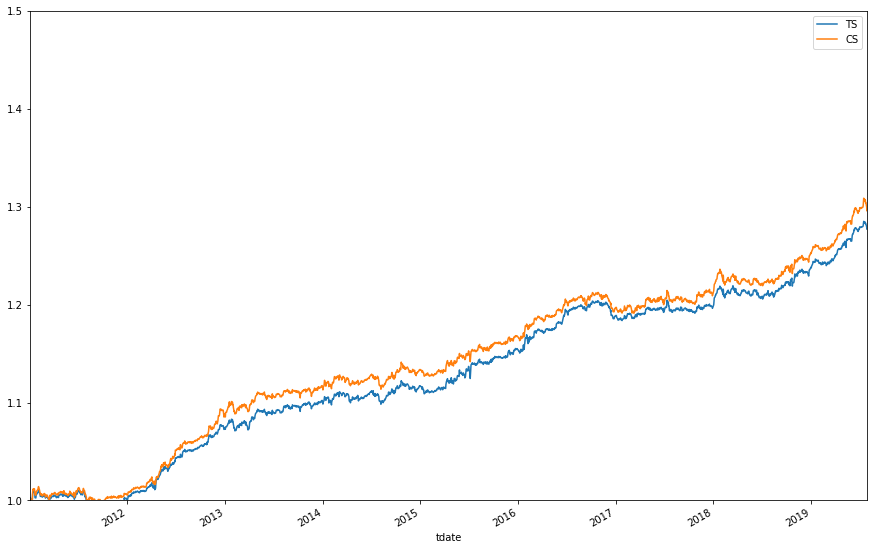

In [130]:
tester = Tester(strategy2)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(1.0, 1.5))

# CASE 3. Case1을 Rolling으로 실행

In [111]:
rolling_one_year = ['2010-12-31',
                    '2011-12-31',
                    '2012-12-31',
                    '2013-12-31',
                    '2014-12-31',
                    '2015-12-31',
                    '2016-12-31',
                    '2017-12-31',
                    '2018-12-31']

In [112]:
def train(train_x, train_y1, val_x, val_y1, num_boost_round=1000, learning_rate=0.01, early_stopping_rounds=50, verbose=None):
    params1 = {"objective": "binary",
          "boosting_type": "gbdt",
          "num_boost_round": num_boost_round,
          'max_depth': 3,
          'num_leaves': 25,
          "learning_rate": learning_rate,
          "feature_fraction": 0.8,
          "subsample": 0.8,
          "verbosity": 1,
          "metric": 'binary_logloss'
          }              
    
    train_data = lgb.Dataset(train_x, train_y1)
    val_data = lgb.Dataset(val_x, val_y1)
    lgb_model = lgb.train(train_set=train_data, params=params1, early_stopping_rounds=early_stopping_rounds,
                          valid_sets=[train_data, val_data], verbose_eval=verbose)
    
    train_pred = lgb_model.predict(train_x)
    val_pred = lgb_model.predict(val_x)
    return lgb_model, train_pred, val_pred

In [113]:
models = []
train_preds = []
test_preds = []

In [114]:
for i, one_year in enumerate(rolling_one_year):
    df_train = df_join.loc[df_join['tdate'] <= pd.to_datetime(rolling_one_year[i])]
    
    if i == len(rolling_one_year) - 1:
        df_test = df_join.loc[df_join['tdate'] > pd.to_datetime(rolling_one_year[i])]
    else:
        df_test = df_join.loc[(df_join['tdate'] <= pd.to_datetime(rolling_one_year[i+1])) & 
                              (df_join['tdate'] > pd.to_datetime(rolling_one_year[i]))]

    df_train_y = df_train['y']
    df_train_x = df_train[df_train.columns[3:]]

    df_test_y = df_test['y']
    df_test_x = df_test[df_test.columns[3:]]
    
    model, train_pred, test_pred = train(df_train_x.values, df_train_y.values, df_test_x.values, df_test_y.values, 
                                        num_boost_round=500, 
                                        learning_rate=0.01, 
                                        verbose=10,
                                        early_stopping_rounds=500)
    
    df_train['y_pred'] = train_pred
    df_test['y_pred'] = test_pred
    
    models.append(model)
    train_preds.append(df_train)
    test_preds.append(df_test)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.692683	valid_1's binary_logloss: 0.692856
[20]	training's binary_logloss: 0.692278	valid_1's binary_logloss: 0.692661
[30]	training's binary_logloss: 0.691921	valid_1's binary_logloss: 0.692499
[40]	training's binary_logloss: 0.691605	valid_1's binary_logloss: 0.692381
[50]	training's binary_logloss: 0.691321	valid_1's binary_logloss: 0.692292
[60]	training's binary_logloss: 0.691066	valid_1's binary_logloss: 0.692213
[70]	training's binary_logloss: 0.690824	valid_1's binary_logloss: 0.692134
[80]	training's binary_logloss: 0.690598	valid_1's binary_logloss: 0.692108
[90]	training's binary_logloss: 0.690383	valid_1's binary_logloss: 0.692093
[100]	training's binary_logloss: 0.690183	valid_1's binary_logloss: 0.692143
[110]	training's binary_logloss: 0.689992	valid_1's binary_logloss: 0.692156
[120]	training's binary_logloss: 0.689812	valid_1's binary_logloss: 0.692137
[130]	training's binary

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.692705	valid_1's binary_logloss: 0.692848
[20]	training's binary_logloss: 0.692316	valid_1's binary_logloss: 0.692605
[30]	training's binary_logloss: 0.691975	valid_1's binary_logloss: 0.69238
[40]	training's binary_logloss: 0.691665	valid_1's binary_logloss: 0.692166
[50]	training's binary_logloss: 0.691392	valid_1's binary_logloss: 0.692007
[60]	training's binary_logloss: 0.691143	valid_1's binary_logloss: 0.691885
[70]	training's binary_logloss: 0.690913	valid_1's binary_logloss: 0.691746
[80]	training's binary_logloss: 0.690698	valid_1's binary_logloss: 0.691653
[90]	training's binary_logloss: 0.690496	valid_1's binary_logloss: 0.691619
[100]	training's binary_logloss: 0.690297	valid_1's binary_logloss: 0.691595
[110]	training's binary_logloss: 0.690112	valid_1's binary_logloss: 0.691542
[120]	training's binary_logloss: 0.68993	valid_1's binary_logloss: 0.691527
[130]	training's binary_l

[90]	training's binary_logloss: 0.69065	valid_1's binary_logloss: 0.692336
[100]	training's binary_logloss: 0.690473	valid_1's binary_logloss: 0.692328
[110]	training's binary_logloss: 0.690294	valid_1's binary_logloss: 0.692334
[120]	training's binary_logloss: 0.690119	valid_1's binary_logloss: 0.692363
[130]	training's binary_logloss: 0.689961	valid_1's binary_logloss: 0.69236
[140]	training's binary_logloss: 0.689807	valid_1's binary_logloss: 0.692366
[150]	training's binary_logloss: 0.68965	valid_1's binary_logloss: 0.692369
[160]	training's binary_logloss: 0.689494	valid_1's binary_logloss: 0.692352
[170]	training's binary_logloss: 0.689322	valid_1's binary_logloss: 0.692356
[180]	training's binary_logloss: 0.689152	valid_1's binary_logloss: 0.692358
[190]	training's binary_logloss: 0.688978	valid_1's binary_logloss: 0.692371
[200]	training's binary_logloss: 0.688816	valid_1's binary_logloss: 0.692369
[210]	training's binary_logloss: 0.688661	valid_1's binary_logloss: 0.69237
[220

[210]	training's binary_logloss: 0.689005	valid_1's binary_logloss: 0.692427
[220]	training's binary_logloss: 0.688856	valid_1's binary_logloss: 0.692423
[230]	training's binary_logloss: 0.688711	valid_1's binary_logloss: 0.692415
[240]	training's binary_logloss: 0.688559	valid_1's binary_logloss: 0.692425
[250]	training's binary_logloss: 0.688415	valid_1's binary_logloss: 0.692447
[260]	training's binary_logloss: 0.688289	valid_1's binary_logloss: 0.692429
[270]	training's binary_logloss: 0.688158	valid_1's binary_logloss: 0.692417
[280]	training's binary_logloss: 0.688031	valid_1's binary_logloss: 0.692414
[290]	training's binary_logloss: 0.687894	valid_1's binary_logloss: 0.692422
[300]	training's binary_logloss: 0.687769	valid_1's binary_logloss: 0.692421
[310]	training's binary_logloss: 0.687641	valid_1's binary_logloss: 0.692433
[320]	training's binary_logloss: 0.687515	valid_1's binary_logloss: 0.692432
[330]	training's binary_logloss: 0.687385	valid_1's binary_logloss: 0.692439

[300]	training's binary_logloss: 0.688255	valid_1's binary_logloss: 0.691251
[310]	training's binary_logloss: 0.688131	valid_1's binary_logloss: 0.691232
[320]	training's binary_logloss: 0.688009	valid_1's binary_logloss: 0.691202
[330]	training's binary_logloss: 0.687889	valid_1's binary_logloss: 0.691191
[340]	training's binary_logloss: 0.687782	valid_1's binary_logloss: 0.691173
[350]	training's binary_logloss: 0.687656	valid_1's binary_logloss: 0.691143
[360]	training's binary_logloss: 0.687544	valid_1's binary_logloss: 0.691127
[370]	training's binary_logloss: 0.687436	valid_1's binary_logloss: 0.691124
[380]	training's binary_logloss: 0.687318	valid_1's binary_logloss: 0.691119
[390]	training's binary_logloss: 0.687212	valid_1's binary_logloss: 0.691097
[400]	training's binary_logloss: 0.687103	valid_1's binary_logloss: 0.69109
[410]	training's binary_logloss: 0.686992	valid_1's binary_logloss: 0.691117
[420]	training's binary_logloss: 0.68688	valid_1's binary_logloss: 0.691102
[

In [115]:
df_test_concat = pd.concat(test_preds, axis=0)
df_test_pred = pd.pivot_table(df_test_concat, columns='ticker', index='tdate', values='y_pred')

(array([5.000e+00, 1.100e+01, 2.200e+01, 7.200e+01, 1.320e+02, 1.890e+02,
        4.030e+02, 1.268e+03, 4.040e+03, 8.598e+03, 6.559e+03, 4.446e+03,
        2.880e+03, 1.376e+03, 5.760e+02, 2.590e+02, 1.470e+02, 8.900e+01,
        6.500e+01, 4.800e+01, 2.900e+01, 1.800e+01, 2.800e+01, 9.000e+00,
        5.000e+00, 7.000e+00, 3.000e+00, 1.000e+00, 0.000e+00, 5.000e+00]),
 array([0.35560055, 0.3691028 , 0.38260506, 0.39610731, 0.40960956,
        0.42311181, 0.43661406, 0.45011632, 0.46361857, 0.47712082,
        0.49062307, 0.50412533, 0.51762758, 0.53112983, 0.54463208,
        0.55813433, 0.57163659, 0.58513884, 0.59864109, 0.61214334,
        0.62564559, 0.63914785, 0.6526501 , 0.66615235, 0.6796546 ,
        0.69315685, 0.70665911, 0.72016136, 0.73366361, 0.74716586,
        0.76066811]),
 <a list of 30 Patch objects>)

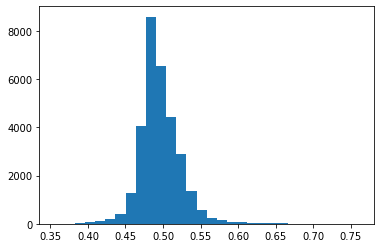

In [116]:
plt.hist(df_test_concat['y_pred'], bins=30)

In [117]:
long = df_test_pred.shape[1] / 10 * 7
short = df_test_pred.shape[1] / 10 * 3

df_pred_rank3 = df_test_pred.rank(axis=1)
df_pred_long3 = (df_pred_rank3 > long).astype(np.float32)
df_pred_short3 = (df_pred_rank3 < short).astype(np.float32)
df_pred_long_short3 = df_pred_long3 - df_pred_short3

In [118]:
strategy3 = EquityStrategy(strategy_name="EPM", asset_type="EQUITY")
strategy3.load_index_and_return(from_db=False, save_file=False)
strategy3.index.columns.name = 'ticker'
strategy3.ret.columns.name = 'ticker'
strategy3.index.drop_duplicates(inplace=True)
strategy3.ret.drop_duplicates(inplace=True)

2019-10-30 18:12:55,367 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-30 18:12:55,367 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-30 18:12:55,367 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-30 18:12:55,367 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-30 18:12:55,369 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-30 18:12:55,369 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-30 18:12:55,369 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-30 18:12:55,369 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-30 18:12:55,370 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-30 18:12:55,370 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-30 18:12:55,370 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-30 18:12:55,370 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [119]:
strategy3.TSRV = df_pred_long_short3
strategy3.CSRV = df_pred_long_short3

strategy3.set_rebalance_period(freq='week', rebalance_weekday=1) 
strategy3.set_portfolio_parameter(cs_strategy_type='vol')
strategy3.make_portfolio()

2019-10-30 18:12:55,413 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 18:12:55,413 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 18:12:55,413 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 18:12:55,413 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 18:12:55,414 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 18:12:55,414 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 18:12:55,414 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 18:12:55,414 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 18:12:55,415 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 18:12:55,415 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 18:12:55,415 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 18:12:55,415 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 18:12:55,417 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 18:12:55,417 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-30 18:12:55,417 - EPM - INFO -

2019-10-30 18:13:58,017 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 18:13:58,017 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 18:13:58,017 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 18:13:58,017 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 18:13:58,017 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 18:13:58,020 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 18:13:58,020 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 18:13:58,020 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 18:13:58,020 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 18:13:58,020 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 18:13:58,028 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 18:13:58,028 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 18:13:58,028 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 18:13:58,028 - EPM - INFO - [STEP 6 - 2] BACKT

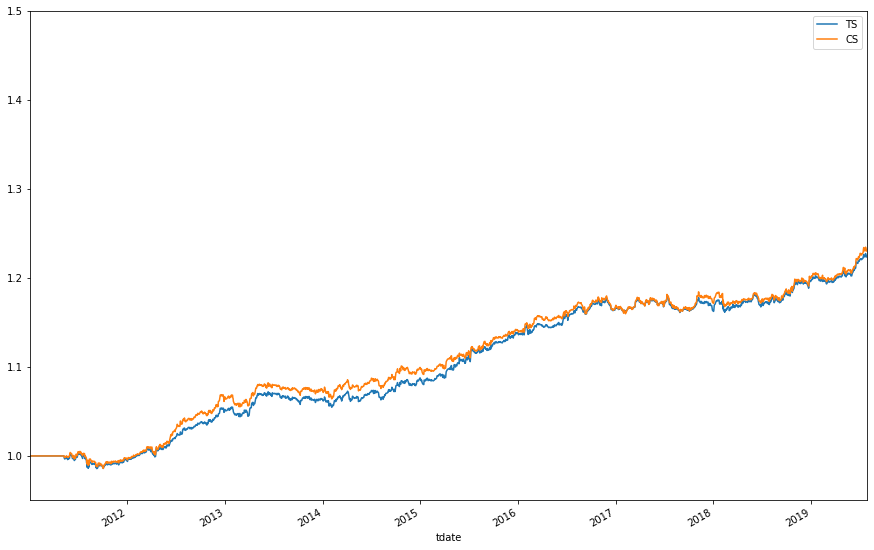

In [129]:
tester = Tester(strategy3)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.95, 1.5))

# CASE 4. CASE 2를 ROLLING으로 실행

In [121]:
models = []
train_preds = []
test_preds = []

In [122]:
for i, one_year in enumerate(rolling_one_year):
    df_train = df_join2.loc[df_join2['tdate'] <= pd.to_datetime(rolling_one_year[i])]
    
    if i == len(rolling_one_year) - 1:
        df_test = df_join.loc[df_join['tdate'] > pd.to_datetime(rolling_one_year[i])]
    else:
        df_test = df_join.loc[(df_join['tdate'] <= pd.to_datetime(rolling_one_year[i+1])) & 
                              (df_join['tdate'] > pd.to_datetime(rolling_one_year[i]))]

    df_train_y = df_train['y']
    df_train_x = df_train[df_train.columns[3:]]

    df_test_y = df_test['y']
    df_test_x = df_test[df_test.columns[3:]]
    
    model, train_pred, test_pred = train(df_train_x.values, df_train_y.values, df_test_x.values, df_test_y.values, 
                                        num_boost_round=500, 
                                        learning_rate=0.01, 
                                        verbose=10,
                                        early_stopping_rounds=500)
    
    df_train['y_pred'] = train_pred
    df_test['y_pred'] = test_pred
    
    models.append(model)
    train_preds.append(df_train)
    test_preds.append(df_test)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.686128	valid_1's binary_logloss: 0.69904
[20]	training's binary_logloss: 0.685419	valid_1's binary_logloss: 0.698965
[30]	training's binary_logloss: 0.684775	valid_1's binary_logloss: 0.699039
[40]	training's binary_logloss: 0.684213	valid_1's binary_logloss: 0.699275
[50]	training's binary_logloss: 0.683713	valid_1's binary_logloss: 0.699543
[60]	training's binary_logloss: 0.683247	valid_1's binary_logloss: 0.699837
[70]	training's binary_logloss: 0.682818	valid_1's binary_logloss: 0.700154
[80]	training's binary_logloss: 0.682432	valid_1's binary_logloss: 0.700377
[90]	training's binary_logloss: 0.682029	valid_1's binary_logloss: 0.70072
[100]	training's binary_logloss: 0.681654	valid_1's binary_logloss: 0.701168
[110]	training's binary_logloss: 0.681312	valid_1's binary_logloss: 0.701551
[120]	training's binary_logloss: 0.680952	valid_1's binary_logloss: 0.701811
[130]	training's binary_l

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.686164	valid_1's binary_logloss: 0.698631
[20]	training's binary_logloss: 0.685461	valid_1's binary_logloss: 0.698197
[30]	training's binary_logloss: 0.684839	valid_1's binary_logloss: 0.697814
[40]	training's binary_logloss: 0.684277	valid_1's binary_logloss: 0.697546
[50]	training's binary_logloss: 0.683778	valid_1's binary_logloss: 0.697328
[60]	training's binary_logloss: 0.683344	valid_1's binary_logloss: 0.697249
[70]	training's binary_logloss: 0.682924	valid_1's binary_logloss: 0.697094
[80]	training's binary_logloss: 0.682535	valid_1's binary_logloss: 0.69699
[90]	training's binary_logloss: 0.682178	valid_1's binary_logloss: 0.69699
[100]	training's binary_logloss: 0.681834	valid_1's binary_logloss: 0.696957
[110]	training's binary_logloss: 0.681512	valid_1's binary_logloss: 0.697039
[120]	training's binary_logloss: 0.681202	valid_1's binary_logloss: 0.696906
[130]	training's binary_l

[140]	training's binary_logloss: 0.681081	valid_1's binary_logloss: 0.698334
[150]	training's binary_logloss: 0.680849	valid_1's binary_logloss: 0.698348
[160]	training's binary_logloss: 0.680619	valid_1's binary_logloss: 0.698437
[170]	training's binary_logloss: 0.680394	valid_1's binary_logloss: 0.698469
[180]	training's binary_logloss: 0.680202	valid_1's binary_logloss: 0.698523
[190]	training's binary_logloss: 0.679979	valid_1's binary_logloss: 0.698583
[200]	training's binary_logloss: 0.679732	valid_1's binary_logloss: 0.698603
[210]	training's binary_logloss: 0.679486	valid_1's binary_logloss: 0.698666
[220]	training's binary_logloss: 0.679245	valid_1's binary_logloss: 0.69868
[230]	training's binary_logloss: 0.679019	valid_1's binary_logloss: 0.698659
[240]	training's binary_logloss: 0.678771	valid_1's binary_logloss: 0.698611
[250]	training's binary_logloss: 0.678528	valid_1's binary_logloss: 0.698619
[260]	training's binary_logloss: 0.678312	valid_1's binary_logloss: 0.698565


[290]	training's binary_logloss: 0.678236	valid_1's binary_logloss: 0.701121
[300]	training's binary_logloss: 0.678041	valid_1's binary_logloss: 0.7012
[310]	training's binary_logloss: 0.677844	valid_1's binary_logloss: 0.701199
[320]	training's binary_logloss: 0.677645	valid_1's binary_logloss: 0.701258
[330]	training's binary_logloss: 0.67745	valid_1's binary_logloss: 0.701245
[340]	training's binary_logloss: 0.677232	valid_1's binary_logloss: 0.701254
[350]	training's binary_logloss: 0.677025	valid_1's binary_logloss: 0.701313
[360]	training's binary_logloss: 0.67683	valid_1's binary_logloss: 0.701384
[370]	training's binary_logloss: 0.676619	valid_1's binary_logloss: 0.701425
[380]	training's binary_logloss: 0.676433	valid_1's binary_logloss: 0.7015
[390]	training's binary_logloss: 0.676221	valid_1's binary_logloss: 0.701439
[400]	training's binary_logloss: 0.676001	valid_1's binary_logloss: 0.701408
[410]	training's binary_logloss: 0.675808	valid_1's binary_logloss: 0.701424
[420]

[420]	training's binary_logloss: 0.676638	valid_1's binary_logloss: 0.697773
[430]	training's binary_logloss: 0.676478	valid_1's binary_logloss: 0.697749
[440]	training's binary_logloss: 0.676302	valid_1's binary_logloss: 0.69746
[450]	training's binary_logloss: 0.676084	valid_1's binary_logloss: 0.697434
[460]	training's binary_logloss: 0.675889	valid_1's binary_logloss: 0.697414
[470]	training's binary_logloss: 0.6757	valid_1's binary_logloss: 0.69739
[480]	training's binary_logloss: 0.675486	valid_1's binary_logloss: 0.697369
[490]	training's binary_logloss: 0.6753	valid_1's binary_logloss: 0.697338
[500]	training's binary_logloss: 0.675118	valid_1's binary_logloss: 0.69731
Did not meet early stopping. Best iteration is:
[500]	training's binary_logloss: 0.675118	valid_1's binary_logloss: 0.69731
Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.686294	valid_1's binary_logloss: 0.702339
[20]	training's binary_logloss: 0.685717	valid_1's b

In [123]:
df_test_concat = pd.concat(test_preds, axis=0)
df_test_pred = pd.pivot_table(df_test_concat, columns='ticker', index='tdate', values='y_pred')

long = df_test_pred.shape[1] / 10 * 7
short = df_test_pred.shape[1] / 10 * 3

In [124]:
df_pred_rank4 = df_test_pred.rank(axis=1)
df_pred_long4 = (df_pred_rank4 > long).astype(np.float32)
df_pred_short4 = (df_pred_rank4 < short).astype(np.float32)
df_pred_long_short4 = df_pred_long4 - df_pred_short4

In [125]:
strategy4 = EquityStrategy(strategy_name="EPM", asset_type="EQUITY")
strategy4.load_index_and_return(from_db=False, save_file=False)
strategy4.index.columns.name = 'ticker'
strategy4.ret.columns.name = 'ticker'
strategy4.index.drop_duplicates(inplace=True)
strategy4.ret.drop_duplicates(inplace=True)

2019-10-30 18:13:21,910 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-30 18:13:21,910 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-30 18:13:21,910 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-30 18:13:21,910 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-30 18:13:21,910 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-30 18:13:21,913 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-30 18:13:21,913 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-30 18:13:21,913 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-30 18:13:21,913 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-30 18:13:21,913 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-30 18:13:21,915 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-30 18:13:21,915 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-30 18:13:21,915 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-30 18:13:21,915 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-30 18:13:21,915 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [126]:
strategy4.TSRV = df_pred_long_short4
strategy4.CSRV = df_pred_long_short4

strategy4.set_rebalance_period(freq='week', rebalance_weekday=1) 
strategy4.set_portfolio_parameter(cs_strategy_type='vol')
strategy4.make_portfolio()

2019-10-30 18:13:21,963 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 18:13:21,963 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 18:13:21,963 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 18:13:21,963 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 18:13:21,963 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-30 18:13:21,964 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 18:13:21,964 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 18:13:21,964 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 18:13:21,964 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 18:13:21,964 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-30 18:13:21,966 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 18:13:21,966 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 18:13:21,966 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 18:13:21,966 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-30 18:13:21,966 - EPM - INFO - [STE

2019-10-30 18:13:48,706 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 18:13:48,706 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 18:13:48,706 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 18:13:48,706 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 18:13:48,706 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-30 18:13:48,709 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 18:13:48,709 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 18:13:48,709 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 18:13:48,709 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 18:13:48,709 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-30 18:13:48,717 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 18:13:48,717 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 18:13:48,717 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-30 18:13:48,717 - EPM - INFO - [STEP 6 - 2] BACKT

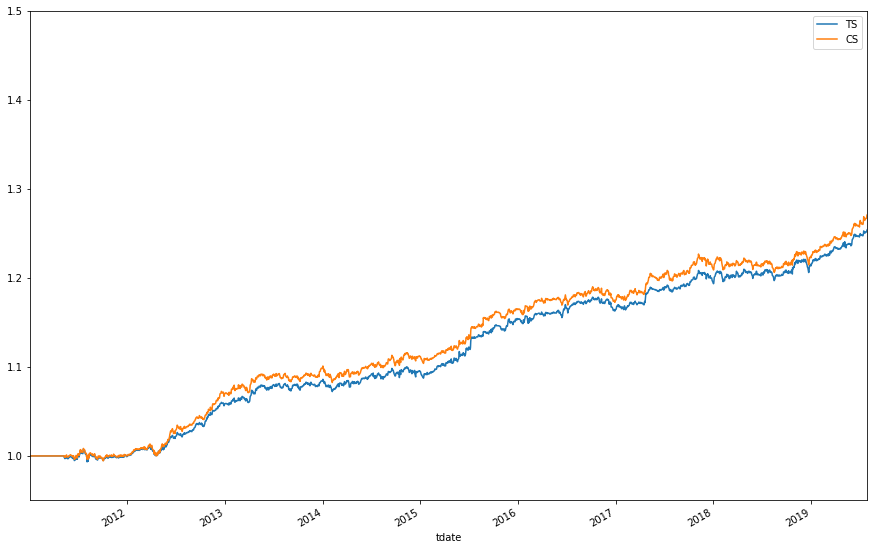

In [128]:
tester = Tester(strategy4)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.95, 1.5))